## Quick RAG overview :- 

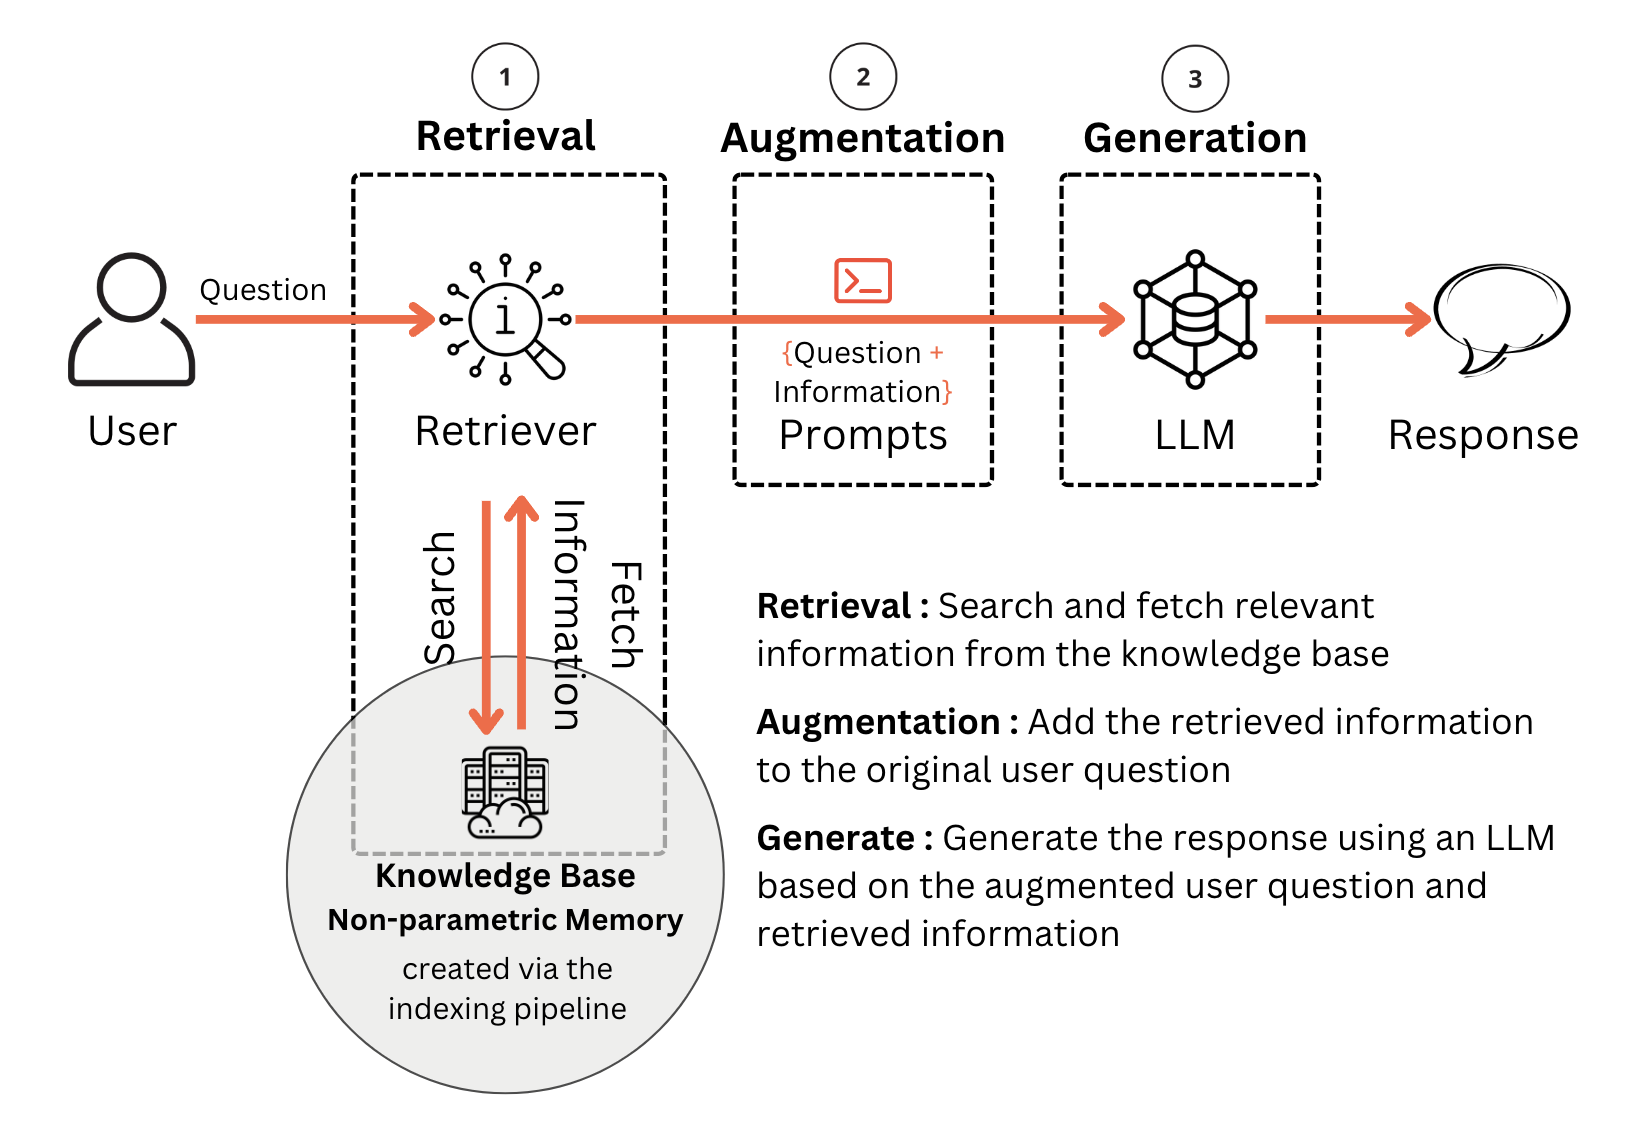

### __Load the Vector Index__

In [1]:
from dotenv import load_dotenv
import os
os.environ.pop('GROQ_API_KEY',None)
if load_dotenv():
    print("Success: .env file found with some environment variables")

Success: .env file found with some environment variables


In [ ]:
api_key=os.environ["GROQ_API_KEY"]
# print(api_key)
from openai import OpenAI

client = OpenAI(
    base_url="https://api.groq.com/openai/v1",
    api_key=os.environ.get("GROQ_API_KEY") 
)


In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
from langchain_community.vectorstores import FAISS

# Load the FAISS vector store with safe deserialization
vector_store = FAISS.load_local(folder_path="./Assets/Data/",index_name="CWC_index", embeddings=embeddings, allow_dangerous_deserialization=True)

/Users/shekh-abdullah-ayubi/Documents/RAG-concepts/RAGenv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:27: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1
/Users/shekh-abdullah-ayubi/Documents/RAG-concepts/RAGenv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. __Retrieval__

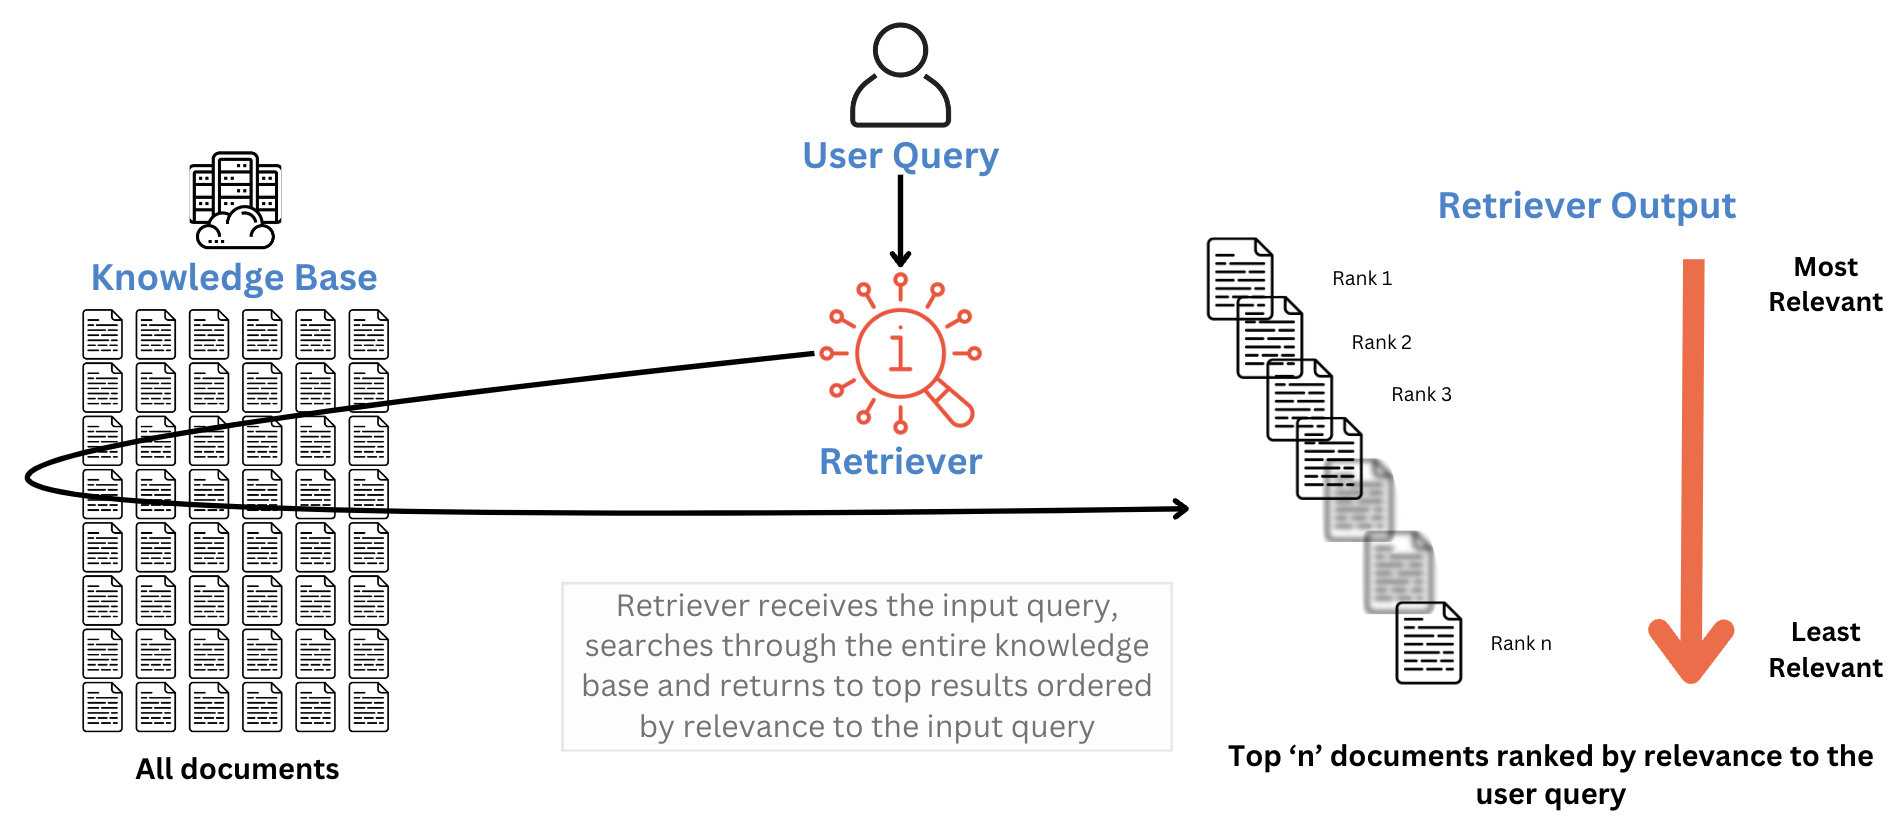


In [5]:
# Original Question
query = "what is Dadasaheb Phalke award ?"
# Ranking the chunks in descending order of similarity
retrieved_docs = vector_store.similarity_search(query,k=3)
# Printing the top ranked chunk
import textwrap

for i, doc in enumerate(retrieved_docs):
    print(textwrap.fill(f"\nRetrieved Chunk {i+1}:\n{doc.page_content}",width=100))
    print("\n\n")

 Retrieved Chunk 1: Dadasaheb Phalke Award   [ edit ]



 Retrieved Chunk 2: 2   Dadasaheb Phalke Award



 Retrieved Chunk 3: Introduced in 1969, the  Dadasaheb Phalke Award  is India's highest award in the
field of cinema given to recognise the contributions of film personalities towards the development
of Indian cinema and for distinguished contributions to the medium, its growth and promotion. The
recipient is awarded with 'Golden Lotus Award' (Swarna Kamal), cash prize of  ₹ 10 lakh
(US$12,000), medallion and a shawl. The 2023 recipient is  Mohanlal . [ 10 ] [ 11 ]





## 2. __Augmentation__
The information fetched by the retriever should also be sent to the LLM in form of a natural language prompt. This process of combining the user query and the retrieved information is called augmentation.

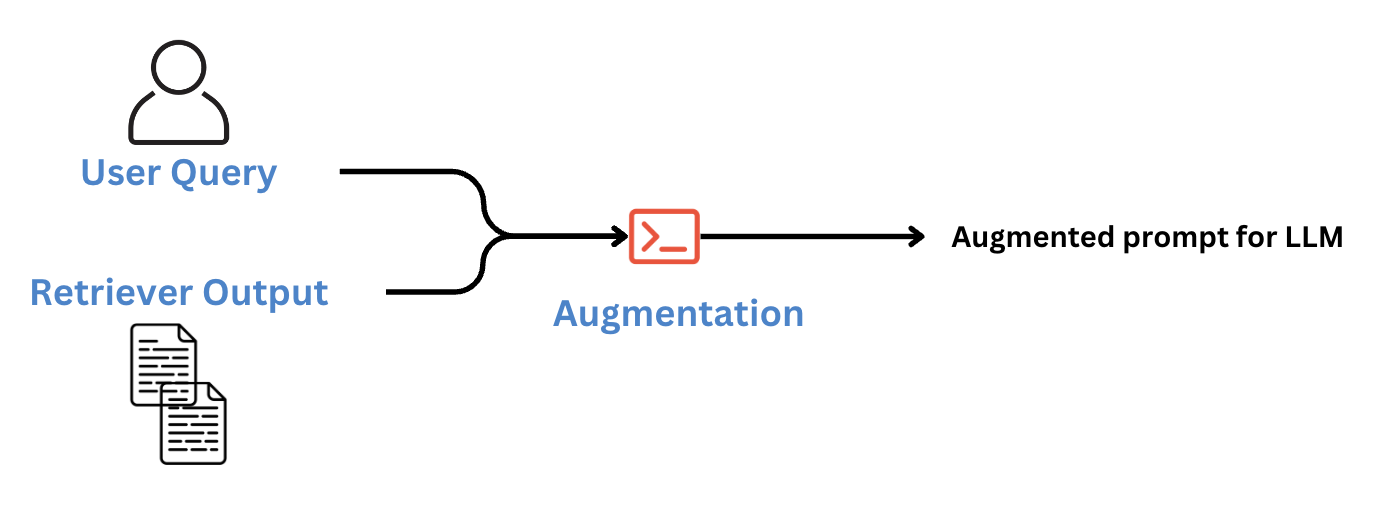



In [7]:
# taking first two retrieved documents
retrieved_context=retrieved_docs[0].page_content + retrieved_docs[1].page_content + retrieved_docs[2].page_content

# Creating the prompt
augmented_prompt=f"""

Given the context below answer the question.

Question: {query} 

Context : {retrieved_context}

Remember to answer only based on the context provided and not from any other source. 

If the question cannot be answered based on the provided context, say I don’t know.

"""

print(textwrap.fill(augmented_prompt,width=150))

  Given the context below answer the question.  Question: what is Dadasaheb Phalke award ?   Context : Dadasaheb Phalke Award   [ edit ]2   Dadasaheb
Phalke AwardIntroduced in 1969, the  Dadasaheb Phalke Award  is India's highest award in the field of cinema given to recognise the contributions of
film personalities towards the development of Indian cinema and for distinguished contributions to the medium, its growth and promotion. The recipient
is awarded with 'Golden Lotus Award' (Swarna Kamal), cash prize of  ₹ 10 lakh  (US$12,000), medallion and a shawl. The 2023 recipient is  Mohanlal . [
10 ] [ 11 ]  Remember to answer only based on the context provided and not from any other source.   If the question cannot be answered based on the
provided context, say I don’t know.


## 3. __Generation__
Generation is the final step of this pipeline. While LLMs may be used in any of the previous steps in the pipeline, the generation step is completely reliant on the LLM. The most popular LLMs are the ones being developed by OpenAI, Anthropic, Meta, Google, Microsoft and Mistral amongst other developers.

In [10]:
from openai.types.chat import ChatCompletionMessageParam

# Prepare the messages list in the format expected by the OpenAI SDK
messages: list[ChatCompletionMessageParam] = [
    {"role": "user", "content": augmented_prompt}
]

# Call the chat completions endpoint
# You can use any Groq model name here https://console.groq.com/docs/deprecations/
chat_completion = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=messages,
    temperature=0,      # Equivalent to the original setting
    max_tokens=None,    # Equivalent to the original setting (handled automatically)
    # timeout and max_retries are handled by the client configuration implicitly
)

# The structure of the response object is standard for the OpenAI SDK
answer = chat_completion.choices[0].message.content

print(answer)

The Dadasaheb Phalke Award is India's highest award in the field of cinema. It was introduced in 1969 and is given to recognise the contributions of film personalities towards the development of Indian cinema and for distinguished contributions to the medium, its growth and promotion.
